In [1]:
# Global imports and settings
%matplotlib inline
from preamble import *
import morelearn as ml
from IPython.display import display, Image
plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
from sklearn.svm import SVC, SVR
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier  

HTML('''<style>html, body{overflow: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

# Machine Learning: an introduction
dr. ir. Joaquin Vanschoren

## Types of machine learning
We often distinguish 3 `types` of machine learning:

- __Supervised Learning__: learn a model from labeled _training data_, then make predictions
- __Unsupervised Learning__: explore the structure of the data to extract meaningful information
- __Reinforcement Learning__: develop an agent that improves its performance based on interactions with the environment

### Classification

- Given: a number of variables (features) $x_1$, $x_2$,...
- Goal: predict a _class label_ (category), e.g. spam/not spam

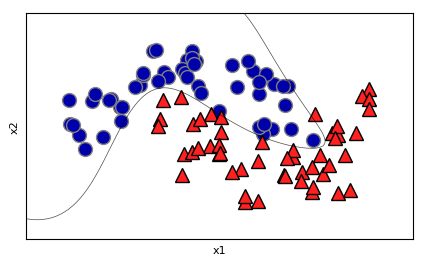

In [22]:
X, y = make_moons(noise=0.2)
clf = SVC(kernel="rbf", C=1000).fit(X, y)
mglearn.plots.plot_2d_separator(clf, X, fill=False, eps=0.5, alpha=.7);
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("x1")
plt.ylabel("x2");

### Regression

- Given: a number of variables (features) $x_1$, $x_2$,...
- Goal: predict a numeric value, e.g. temperature

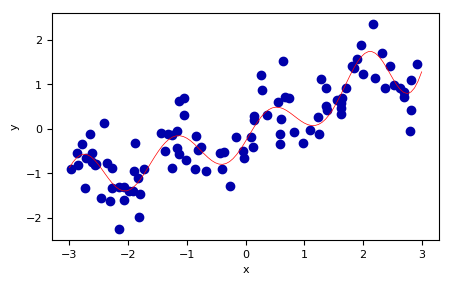

In [23]:
Xr, yr = mglearn.datasets.make_wave()
Xr_pred = np.linspace(-3, 3, 100).reshape(-1, 1)
svr_pred = SVR(kernel="rbf", C=100).fit(Xr, yr).predict(Xr_pred)
plt.scatter(Xr, yr)
plt.plot(Xr_pred, svr_pred, color='red')
plt.xlabel("x")
plt.ylabel("y");

## To date or not to date?

In [4]:
dating_data = pd.DataFrame({"Day of Week":['weekday','weekend','weekend','weekend','weekend'],
                   "Type of Date":['dinner','club','club','club','club'],
                   "Weather":['warm','warm','warm','cold','cold'],
                   "TV tonight":['bad','bad','bad','good','bad'],
                   "Date?":['no','yes','yes','no','?']
                   });
dating_data = dating_data[['Day of Week', 'Type of Date', 'Weather', 'TV tonight', 'Date?']] 

In [5]:
dating_data

,Day of Week,Type of Date,Weather,TV tonight,Date?
0,weekday,dinner,warm,bad,no
1,weekend,club,warm,bad,yes
2,weekend,club,warm,bad,yes
3,weekend,club,cold,good,no
4,weekend,club,cold,bad,?


* Can you see a pattern?
    * Weekend + warm?
    * Club + TV bad?

* There's no way to know!
    * More data? What if there's an unknown variable?
    * What if the answer is just random?

* Machine learning algorithms have to make assumptions (bias)
* Can be any combination of:
    * __Representation__: how to express hypotheses?
        * E.g. combination of variables, neural net,...
    * __Evaluation__: how to choose the best hypothesis?
        * How correct are my predictions?
    * __Optimization__: how to search for the best hypothesis? 
        * You can't try all of them

# k-Nearest Neighbor

* Remember all data
* To make a prediction, find the _k_ closest examples in the training data

## k-Nearest Neighbor Classification

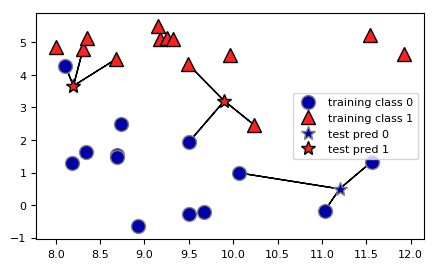

In [27]:
mglearn.plots.plot_knn_classification(n_neighbors=3)

If we plot the prediction for each possible input we see the _decision boundary_

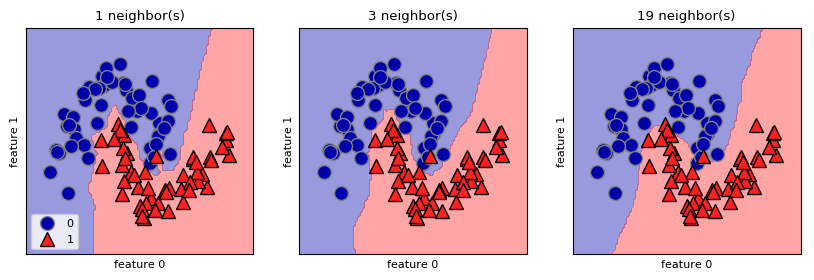

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for n_neighbors, ax in zip([1, 3, 19], axes):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=True, eps=0.5, ax=ax, alpha=.4)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel("feature 0")
    ax.set_ylabel("feature 1")
_ = axes[0].legend(loc=3)

## k-Neighbors Regression

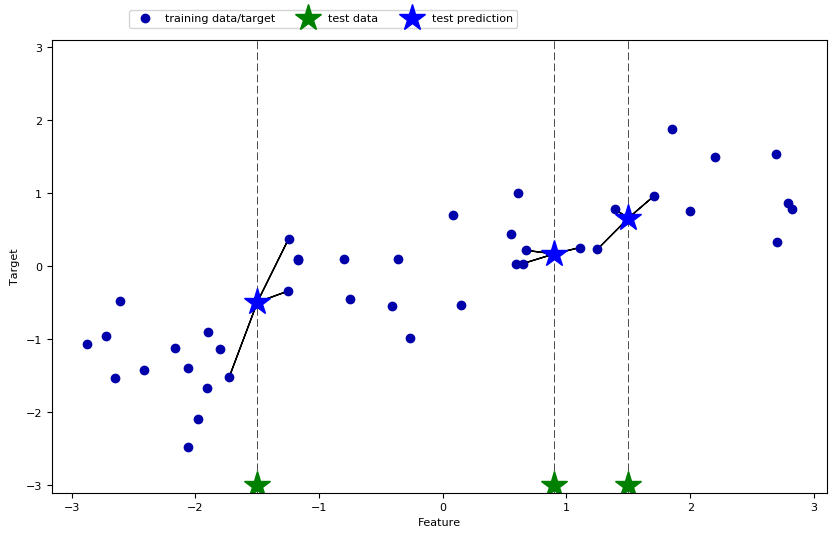

In [31]:
mglearn.plots.plot_knn_regression(n_neighbors=3)

If we plot the prediction for each possible input we see the _decision boundary_

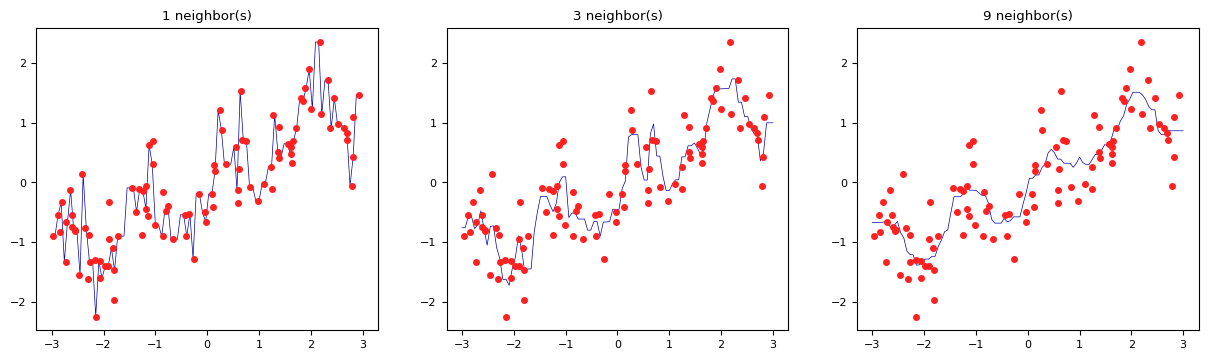

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
line = np.linspace(-3, 3, 100).reshape(-1, 1)
for n_neighbors, ax in zip([1, 3, 9], axes):
    reg = KNeighborsRegressor(n_neighbors=n_neighbors).fit(Xr, yr)
    ax.plot(line, reg.predict(line))
    ax.plot(Xr, yr, '.', c=mglearn.cm2(1), markersize=8)
    ax.set_title("%s neighbor(s)" % (n_neighbors))

## k-Nearest Neighbors: take-aways
* Easy to understand, works well in many settings
* No training (just store all data), predicting is slow for large datasets
    * We need special data structures
* Bad at high-dimensional data (but we can often reduce dimensions)
* Number of neighbors needs to be tuned to the data

# Decision trees

* Split the data in two (or more) parts
* Find the split that is most informative (e.g. separates the classes)
* Repeat recursively, this yields a _decision tree_

## Decision tree classification

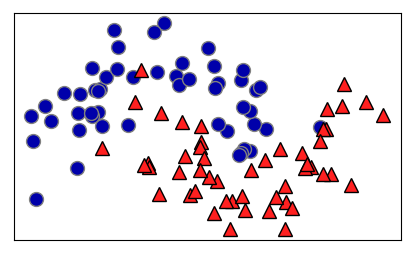

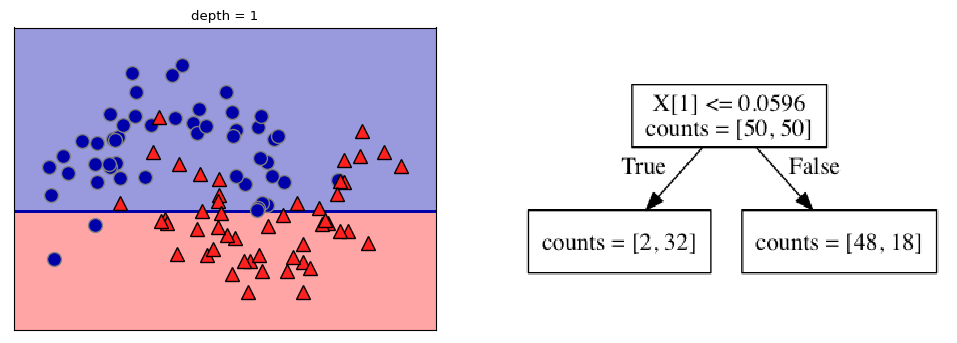

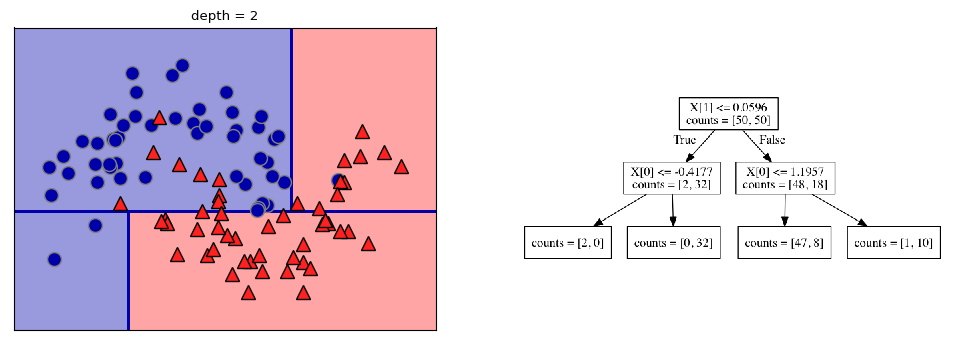

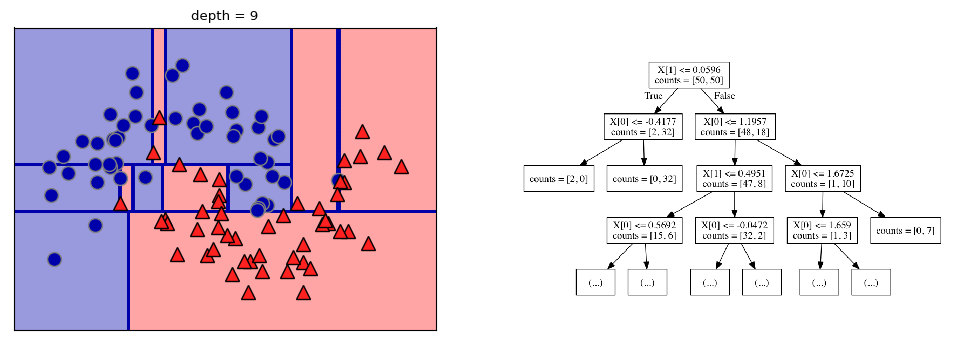

In [10]:
mglearn.plots.plot_tree_progressive()

Most informative split? Different heuristics to get 'pure leafs'.

- Entropy (of the class attribute) measures *unpredictability* of the data:
    - How likely will random example have class k?
$$ E(X) = -\sum_{k=1}^K \hat{p}_k \log_{2}\hat{p}_k $$

- Information Gain (a.k.a. Kullback–Leibler divergence) for choosing attribute $X_i$ to split the data:
$$ G(X,X_i) = E(X) - \sum_{v=1}^V \frac{|X_{i=v}|}{|X_{i}|} E(X_{i=v}) $$

with $\hat{p}_k$ = the relative frequency of class $k$ in the leaf node,  $X$ = the training set, containing $i$ features (variables) $X_i$, $v$ a specific value for $X_i$, $X_{i=v}$ is the set of examples having value $v$ for feature $X_i$: $\{x \in X | X_i = v\}$

## Decision tree regression

In [11]:
def plot_decision_tree_regression(regr_1, regr_2):
    # Create a random dataset
    rng = np.random.RandomState(1)
    X = np.sort(5 * rng.rand(80, 1), axis=0)
    y = np.sin(X).ravel()
    y[::5] += 3 * (0.5 - rng.rand(16))

    # Fit regression model
    regr_1.fit(X, y)
    regr_2.fit(X, y)

    # Predict
    X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    y_1 = regr_1.predict(X_test)
    y_2 = regr_2.predict(X_test)

    # Plot the results
    plt.figure(figsize=(8,6))
    plt.scatter(X, y, c="darkorange", label="data")
    plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
    plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Decision Tree Regression")
    plt.legend()
    plt.show()

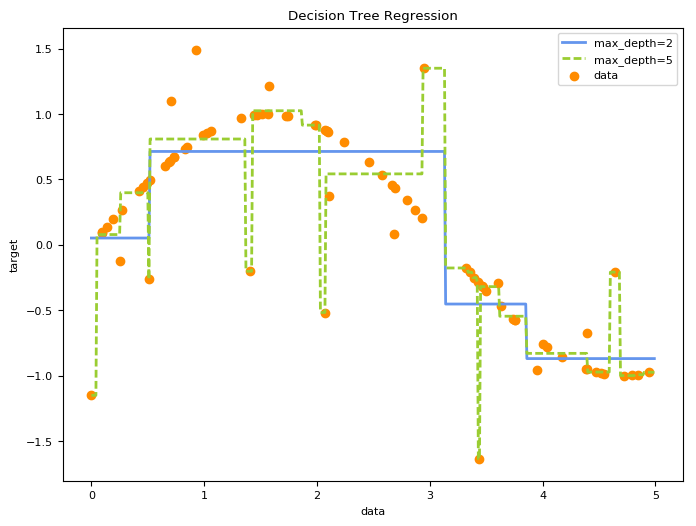

In [12]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
plot_decision_tree_regression(regr_1,regr_2)

# Ensemble learning
Ensembles are methods that combine multiple machine learning models to create more powerful models. Most popular are:

* __RandomForests__: Build randomized trees on random samples of the data
* __Gradient boosting machines__: Build trees iteratively, giving higher weights to the points misclassified by previous trees

## Random Forest classification

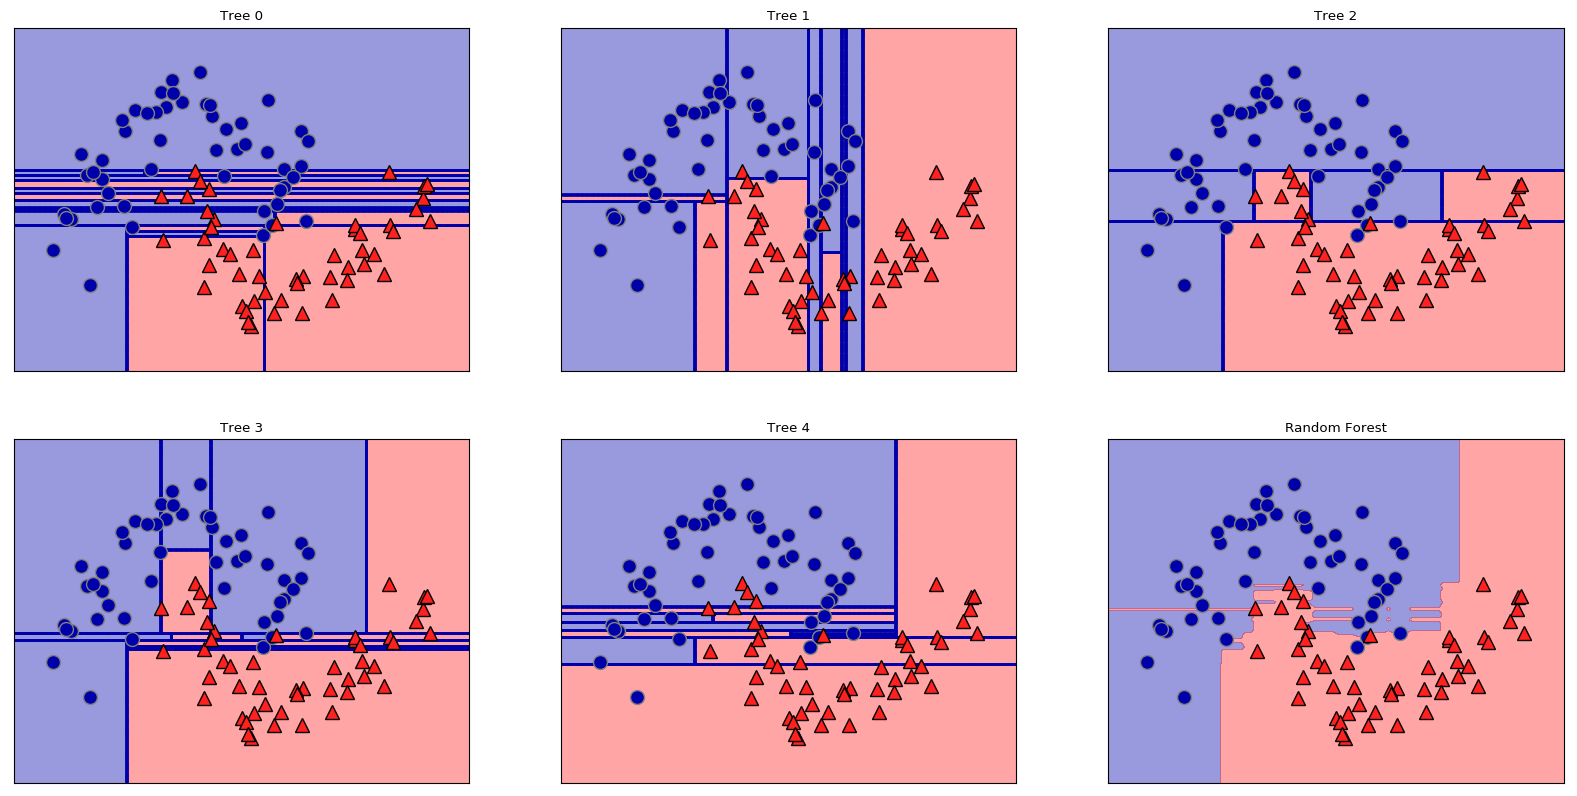

In [13]:
forest = RandomForestClassifier(n_estimators=5, random_state=2).fit(X, y) 
 
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X, y, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

## Gradient boosting classification
- Build a single tree
- Misclassified points get higher weight (larger dots)
- Iterate

![boosting](./images/04_boosting_0.png)
![boosting](./images/04_boosting_1.png)
![boosting](./images/04_boosting_3.png)
![boosting](./images/04_boosting_20.png)

# Linear models
* Make a prediction using a linear function of the input features. 
* Can be very powerful for or datasets with many features. 
* Can be made non-linear in different ways

## Linear models for regression

Prediction formula for input features x. $w_i$ and b are the _model parameters_ that need to be learned.  

$\hat{y} = w_0 * x_0 + w_1 * x_1 + ... + w_p * x_p + b$

w[0]: 0.393906  b: -0.031804


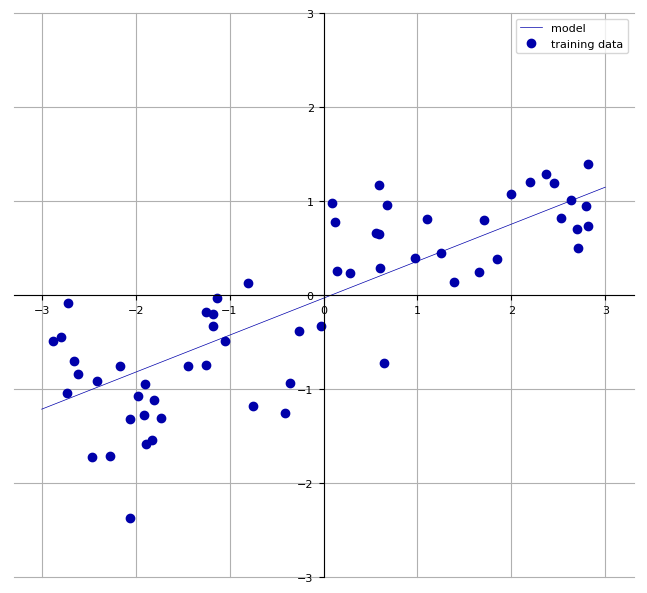

In [14]:
mglearn.plots.plot_linear_regression_wave()

* Several ways to find optimal coefficients
* Least squares: minimize sum of (squared) residuals using linear algebra
![least squares](./images/02_least_squares.png)

## Neural Networks
* An entirely different branch of machine learning, that aims to reverse-engineer the human brain
* Very successful in image/sound/time series data (deep learning)

How does the human brain learn?

- Neuron triggers, sends action potential (voltage) through axon
- Transmission across synapse is chemical
    - Action potential causes release of neurotransmitters
    - Diffuse over to other side, create signal in next dendrite
    - Synapse connection can be weak or strong
- **Hebbian learning**: neurons that fire together, wire together
    - Synapses grow stronger through experience
    - Long-term potentiation: more dendritic receptors

This can be modelled (in a very, very simplified way) by the _perceptron_:
* Neurons are nodes
* They each get a number of inputs (dendrites)
* And each input is weighted (synapse sensitivity)

Learning = learning the weights so that the input is mapped to the right output

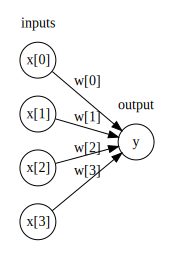

In [15]:
display(mglearn.plots.plot_logistic_regression_graph())

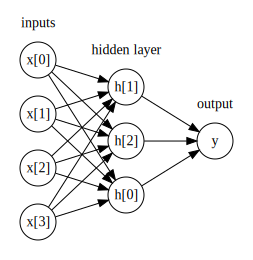

In [16]:
display(mglearn.plots.plot_single_hidden_layer_graph())

## Learning the input weights
- The optimal weights are learned by minimize the squared error of the outputs:
$$E[w] = \frac{1}{2} \sum\limits_{d=1}^{n}  (t_d-o_d)^2 $$
with $n$ training examples, true outputs $t_d$
- Solved using _gradient descent_

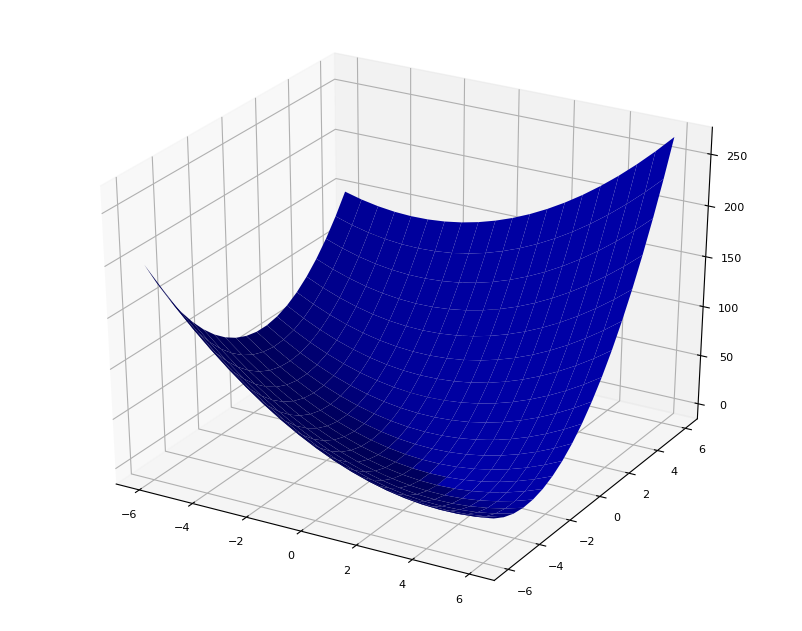

In [17]:
ml.plots.plot_gradient_descent_surface()

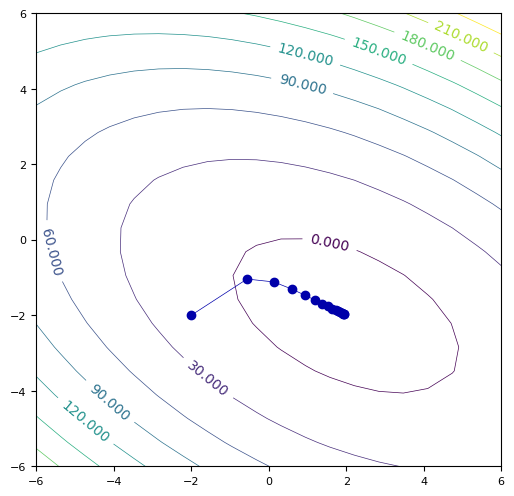

In [36]:
# Also try 0.01, 0.2, 0.27
ml.plots.plot_gradient_descent(alpha=0.12)

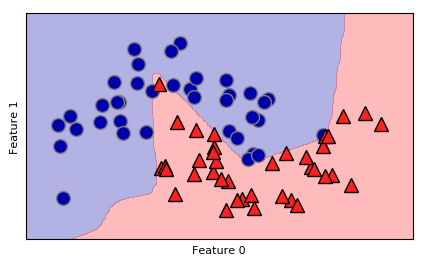

In [19]:
# using one layer, with 10 units, with tanh nonlinearity
# try using 100 or more units
ml.plots.plot_neural_predictions('tanh',[10])

# Thank you
Lots more to learn